# Applying Machine Learning Models

In [56]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [57]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])

print(df_concat.shape)

(9233, 642)


In [58]:
features_act = list()
features_uid = list()

with open('act_feature_importance.txt', 'r') as f:
    features_act = f.read().splitlines()

with open('uid_feature_importance.txt', 'r') as f:
    features_uid = f.read().splitlines()

print(features_act)
print(features_uid)

['angle4()', 't_grav_acc_min()_X', 't_grav_acc_mean()_X', 't_grav_acc_max()_X', 't_grav_acc_min()_Y', 't_grav_acc_energy()_X', 'angle5()', 't_grav_acc_max()_Y', 't_grav_acc_mean()_Y', 't_grav_acc_Mag_energy()', 't_grav_acc_energy()_Y', 't_grav_acc_Mag_min()', 't_grav_acc_Mag_mean()', 't_grav_acc_entropy()_X', 't_body_acc_max()_X', 'angle6()', 'f_body_acc_std()_X', 't_body_acc_Mag_std()', 'f_body_gyro_maxInd()_Z', 'f_body_acc_Jerk_BE[1-8]_X', 'f_body_acc_Mag_kurtosis()', 'f_body_acc_BE[1-8]_Z', 'f_body_acc_BE[1-8]_X', 'f_body_acc_energy()_X', 't_grav_acc_Mag_sma()', 'f_body_acc_Mag_skewness()', 't_body_gyro_Jerk_energy()_X', 't_grav_acc_mean()_Z', 't_grav_acc_min()_Z', 'f_body_acc_BE[1-8]_Y', 'f_body_acc_BE[1-24]_X', 't_body_acc_std()_X', 't_body_acc_Mag_max()', 'f_body_acc_Mag_mean()', 't_body_acc_energy()_X', 't_body_acc_jerk_Mag_iqr()', 't_body_acc_Mag_AR1()', 'f_body_acc_Mag_sma()', 't_grav_acc_max()_Z', 't_body_acc_Corr(X,Y)', 't_body_acc_Mag_entropy()', 'f_body_acc_Jerk_BE[1-8]_Y'

In [59]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [60]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [61]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [62]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

In [63]:
labels_act = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    labels_uid.append(i)

In [64]:
n = 119
# f_add_weighted_noise = set()
# for f in features_uid[:n]:
#   f_add_weighted_noise.add(f)
# print(f_add_weighted_noise)

# n = 211
f_add_weighted_noise = set()
for f in features_uid[:n]:
  # 重複していないものを入れる
  if f not in features_act[:n]:
    f_add_weighted_noise.add(f)
print(len(f_add_weighted_noise))

83


In [65]:
weighted_epsilon_array = [0.001, 0.005, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1]
weighted_epsilon = weighted_epsilon_array[10]

## 2. Random Forest Classifier

## UID

In [66]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_uid = list()
f1_array_random_uid = list()


# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
epsilons = [0.5, 0.7, 0.8, 1.0, 1.2, 1.5, 1.8]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  # for feature in f_add_weighted_noise:
  #   print(X_train[feature])
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   print(X_train[feature])

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    else :
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  
  params = {'n_estimators': np.arange(150,181,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid,  X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_uid)
  f1_array_random_uid.append(f1)
  acc_array_random_uid.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_uid[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_uid)

--------
epsilon:  0.5
--------
training the model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


## HAR

--------
epsilon:  0.1
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:07:13.110558

Predicting test data
==> testing time:- 0:00:00.052467

==> Accuracy:- 0.18116179849031835


 ********Confusion Matrix********

 [[220   7   3   9 176 126]
 [193  13   2  11 169 104]
 [179   8   1   8 140  92]
 [182   9   1  11 166 137]
 [178  10   1  17 184 143]
 [173   7   0  12 232 123]]


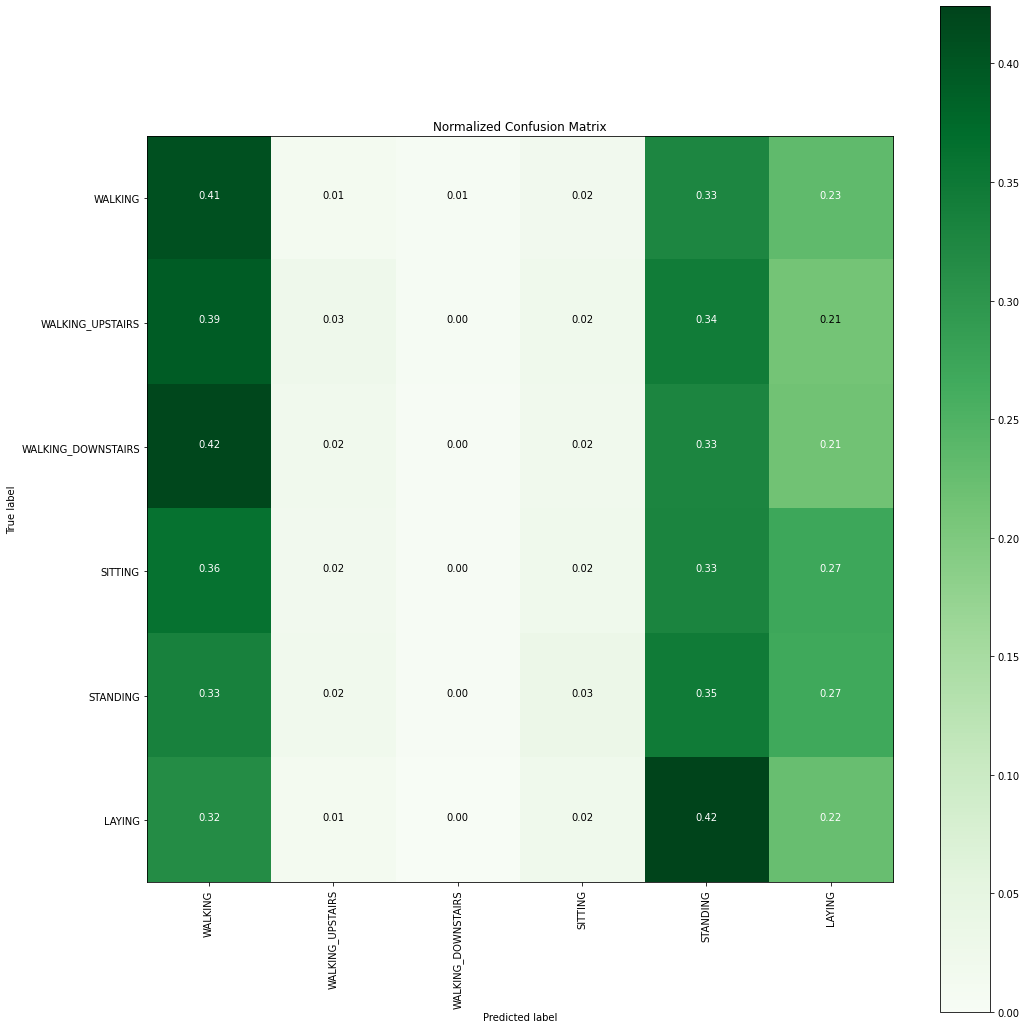


 F1 Score:0.1296725997311253


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.20304034331849294
--------
epsilon:  0.2
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:08:46.266162

Predicting test data
==> testing time:- 0:00:00.049843

==> Accuracy:- 0.26353790613718414


 ********Confusion Matrix********

 [[299   3   2   0 150  87]
 [279   3   2   1 114  93]
 [274   2   0   2  91  59]
 [ 99   1   0   4 254 148]
 [123   0   0   4 247 159]
 [ 94   2   0   7 194 250]]


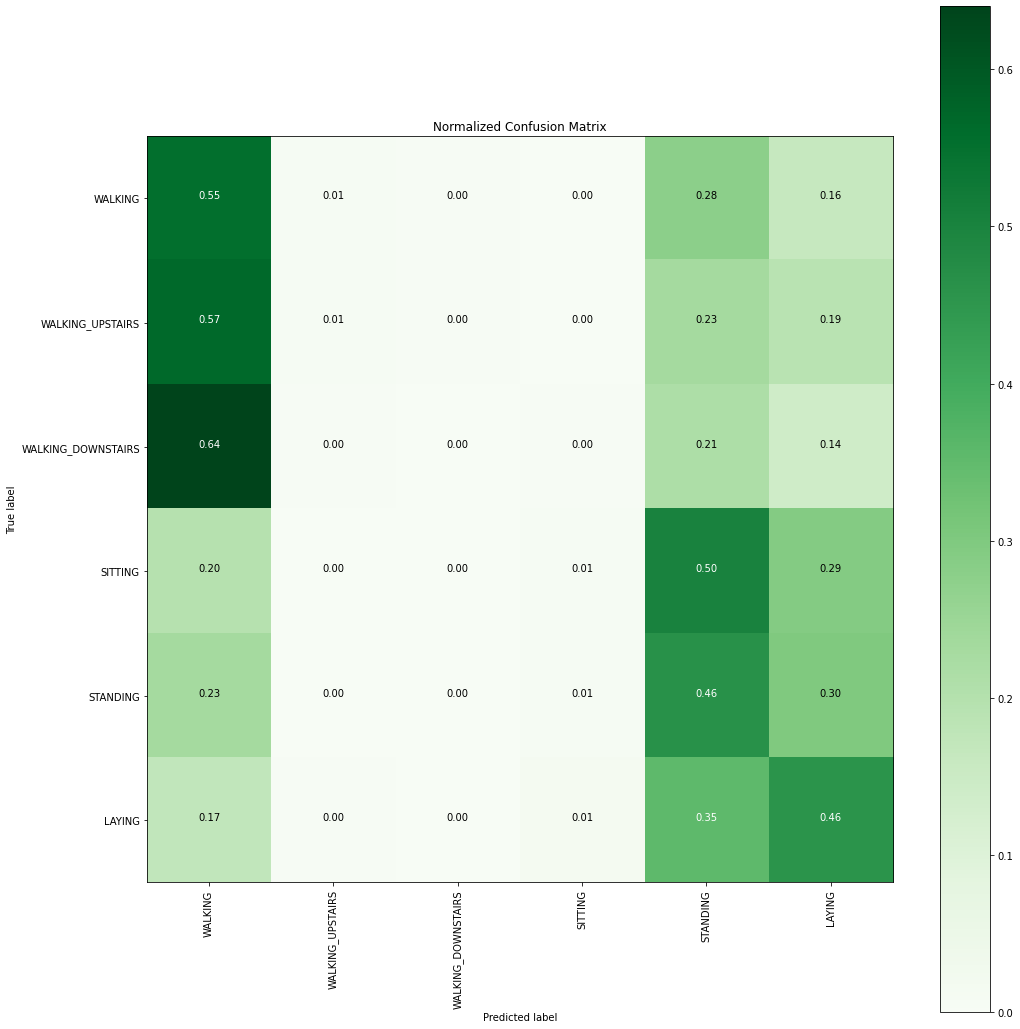


 F1 Score:0.17691239191222938


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.2764297645431714
--------
epsilon:  0.3
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:05:08.758742

Predicting test data
==> testing time:- 0:00:00.057393

==> Accuracy:- 0.319658680669511


 ********Confusion Matrix********

 [[375   5   1   1  89  70]
 [297   6   2   0  97  90]
 [333   2   5   2  44  42]
 [ 64   0   0   4 274 164]
 [ 93   0   0   3 280 157]
 [ 53   0   0   3 187 304]]


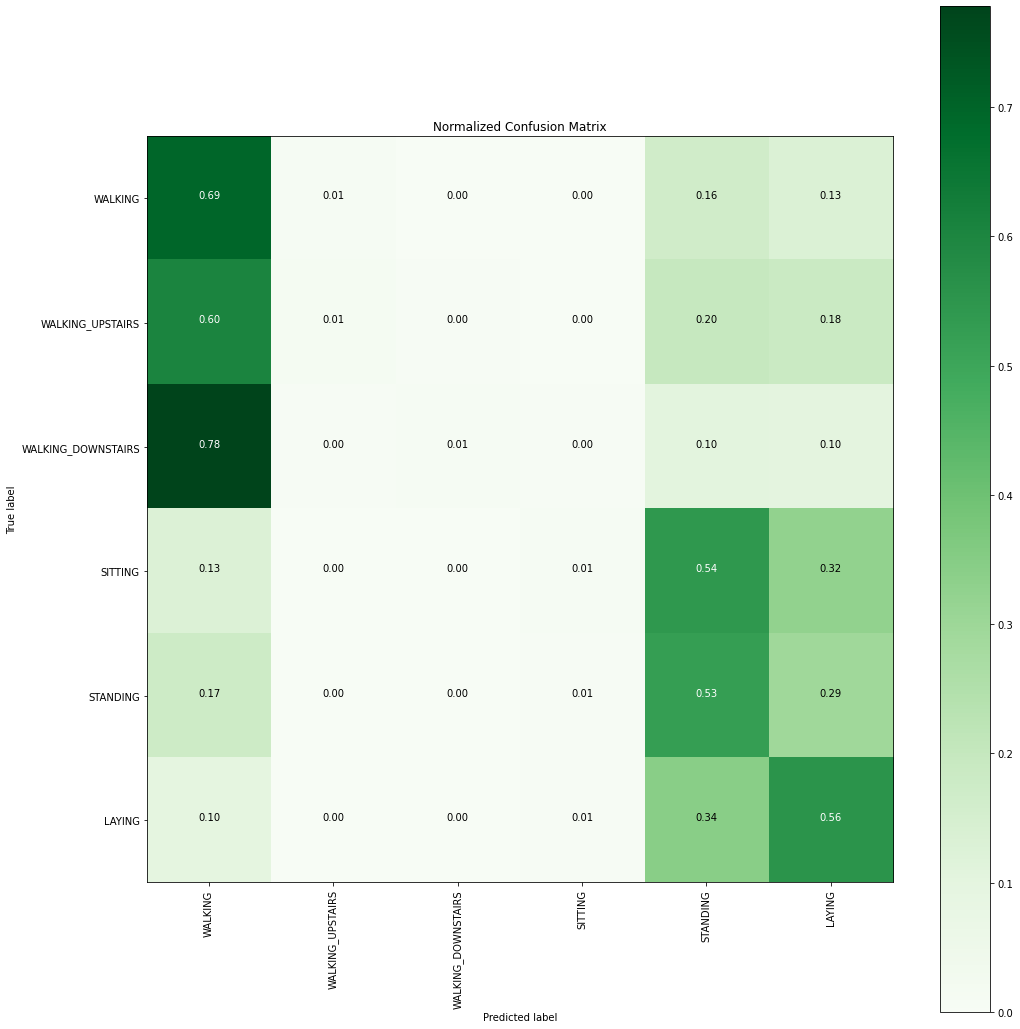


 F1 Score:0.21734392338141384


==> Best Estimator:
	RandomForestClassifier(max_depth=6, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 6, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.3515975515310767
--------
epsilon:  0.5
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:05:33.332979

Predicting test data
==> testing time:- 0:00:00.065099

==> Accuracy:- 0.43944863800459466


 ********Confusion Matrix********

 [[388  33  43   5  47  25]
 [312  33  44   7  62  34]
 [278  25 106   2  11   6]
 [ 21   7   2  39 285 152]
 [ 21   5   0  34 346 127]
 [  8   1   0   9 102 427]]


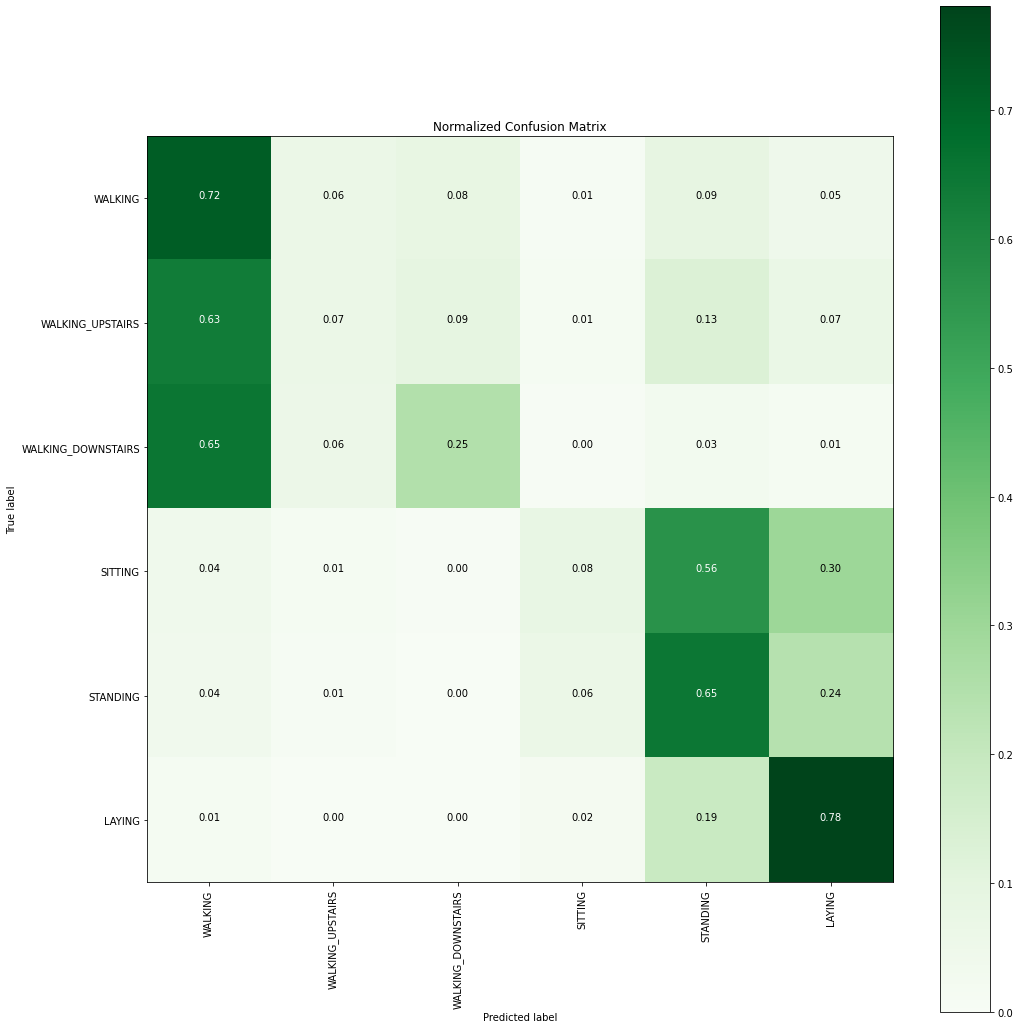


 F1 Score:0.3704012939014385


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.44325776443346826
--------
epsilon:  0.7
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:05:33.690356

Predicting test data
==> testing time:- 0:00:00.066502

==> Accuracy:- 0.5264194289465047


 ********Confusion Matrix********

 [[427  27  59   3  19   6]
 [310  68  62   6  31  15]
 [208  20 189   1   6   4]
 [  5   4   0  37 334 126]
 [  3   2   0  33 385 110]
 [  1   1   0  10  37 498]]


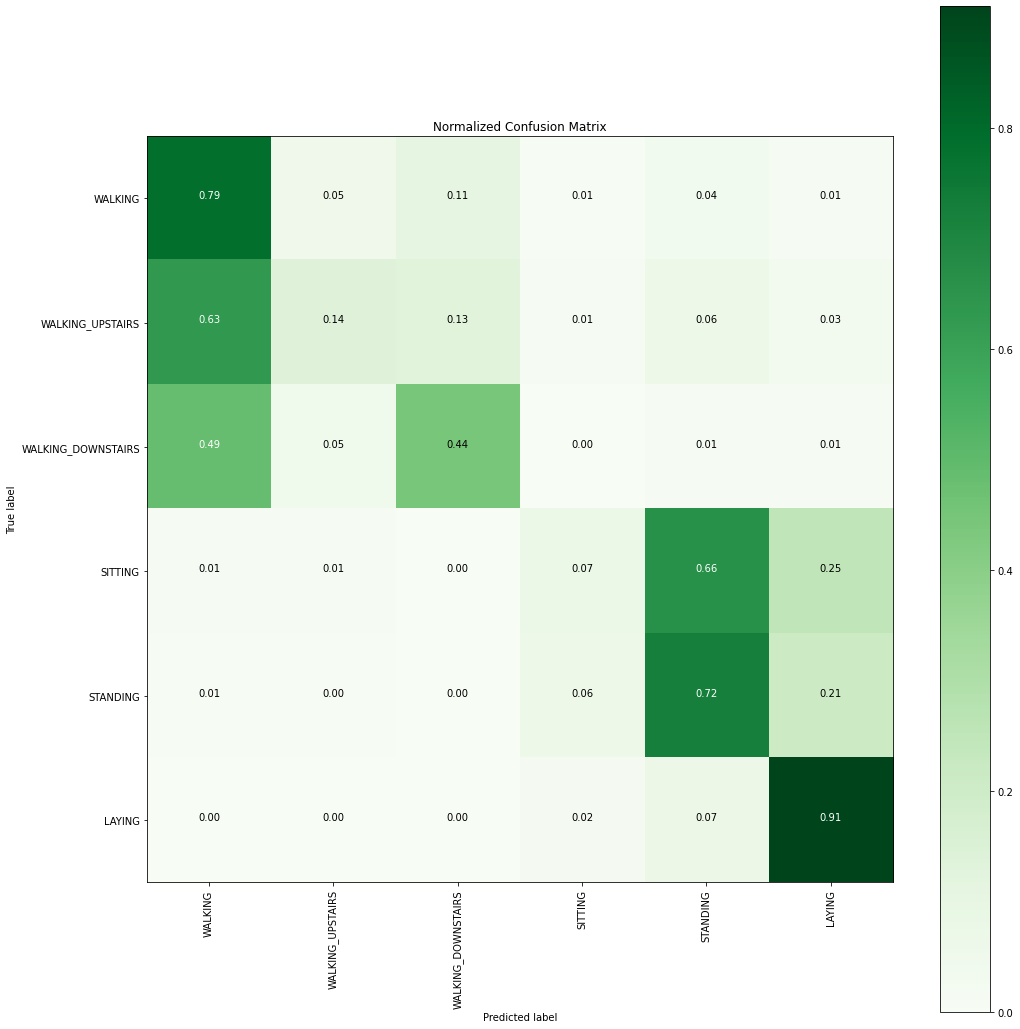


 F1 Score:0.46070278809385384


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5226303148871038
--------
epsilon:  0.8
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:05:33.082565

Predicting test data
==> testing time:- 0:00:00.058199

==> Accuracy:- 0.549721037085658


 ********Confusion Matrix********

 [[406  32  81   1  15   6]
 [285  81  68   4  31  23]
 [168  20 235   0   2   3]
 [  2   1   0  43 344 116]
 [  5   1   0  31 415  81]
 [  0   0   0   6  46 495]]


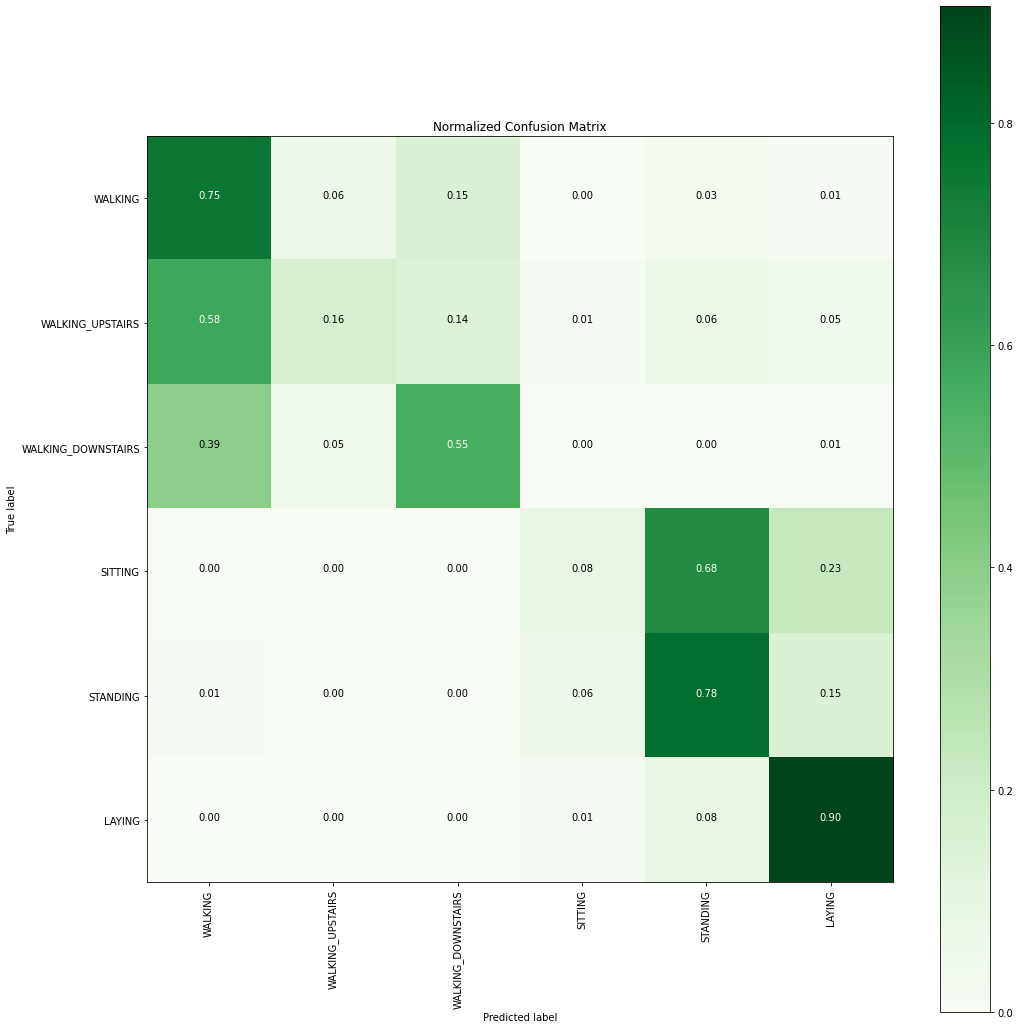


 F1 Score:0.48959688027391085


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5633698705633907
--------
epsilon:  1.0
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:05:33.504999

Predicting test data
==> testing time:- 0:00:00.089944

==> Accuracy:- 0.6110928782408926


 ********Confusion Matrix********

 [[427  49  58   0   4   3]
 [254 148  68   4  13   5]
 [132  31 258   1   5   1]
 [  0   0   0  82 342  82]
 [  0   1   0  64 426  42]
 [  0   0   0   5  21 521]]


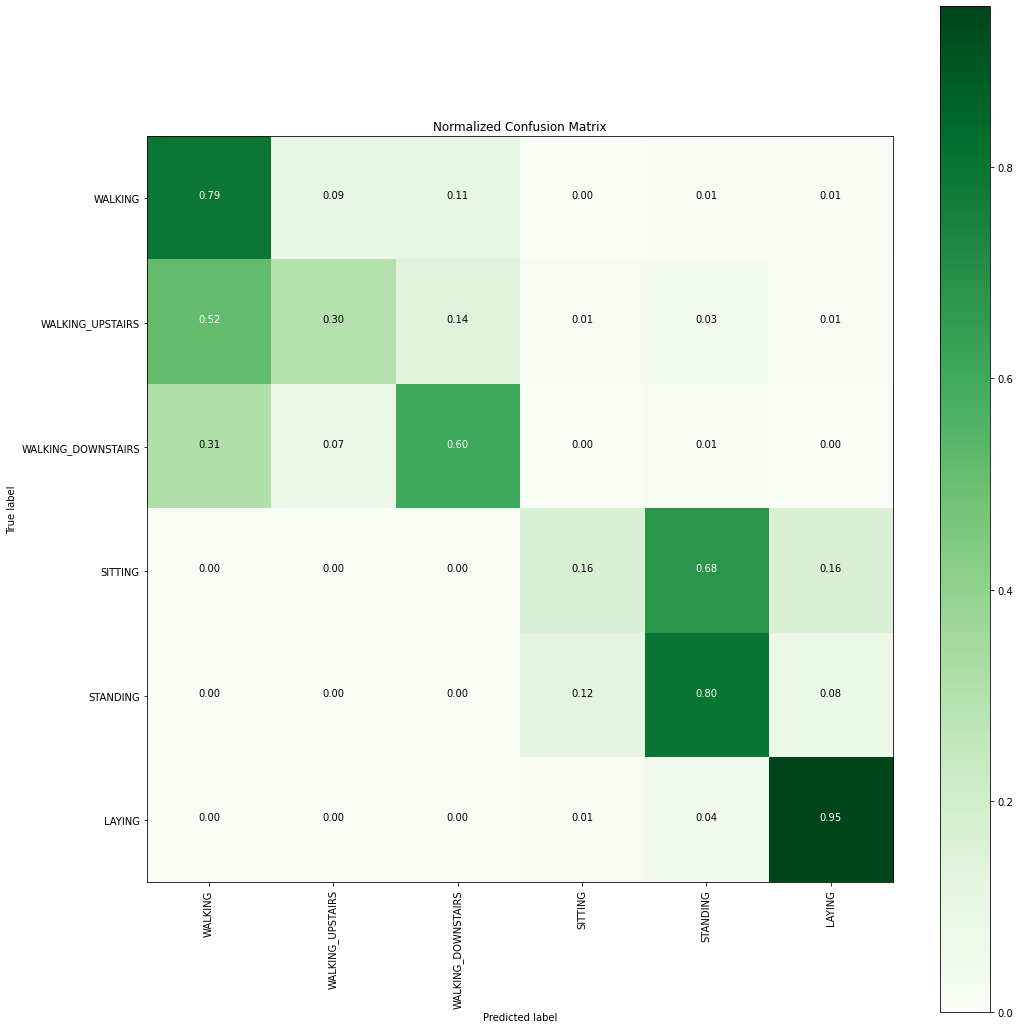


 F1 Score:0.5710009520350171


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6108954777505116
--------
epsilon:  1.2
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:05:39.705340

Predicting test data
==> testing time:- 0:00:00.068240

==> Accuracy:- 0.6458811946176567


 ********Confusion Matrix********

 [[447  37  53   0   3   1]
 [246 165  62   2  15   2]
 [131  24 270   1   1   1]
 [  0   0   0  75 352  79]
 [  0   0   0  30 480  23]
 [  0   0   0   5  11 531]]


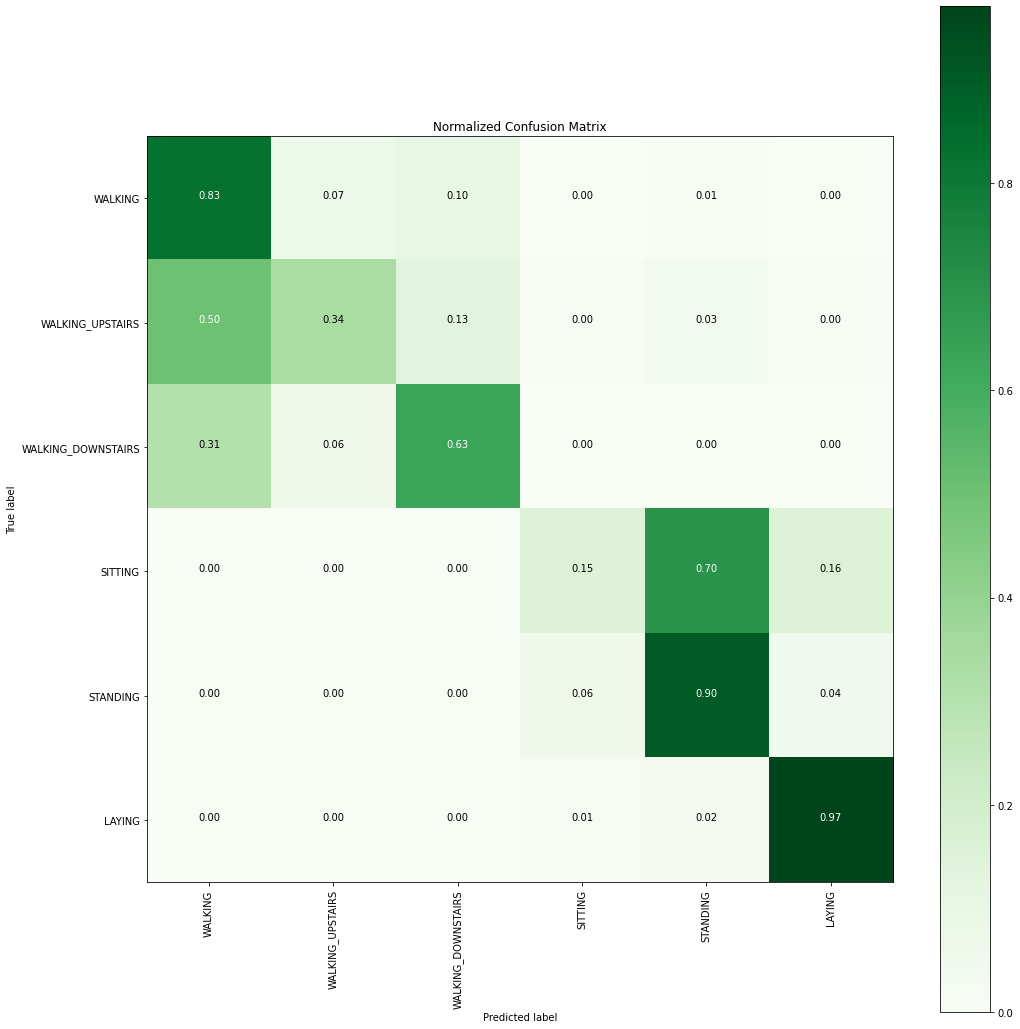


 F1 Score:0.6010365933552785


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6498528802943179
--------
epsilon:  1.5
--------
training the model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done
==> training time:- 0:05:59.222631

Predicting test data
==> testing time:- 0:00:00.084988

==> Accuracy:- 0.6921562192320315


 ********Confusion Matrix********

 [[461  38  36   1   4   1]
 [208 229  42   2  10   1]
 [103  31 292   0   2   0]
 [  0   0   0 127 333  46]
 [  0   0   0  59 462  12]
 [  0   0   0   5   4 538]]


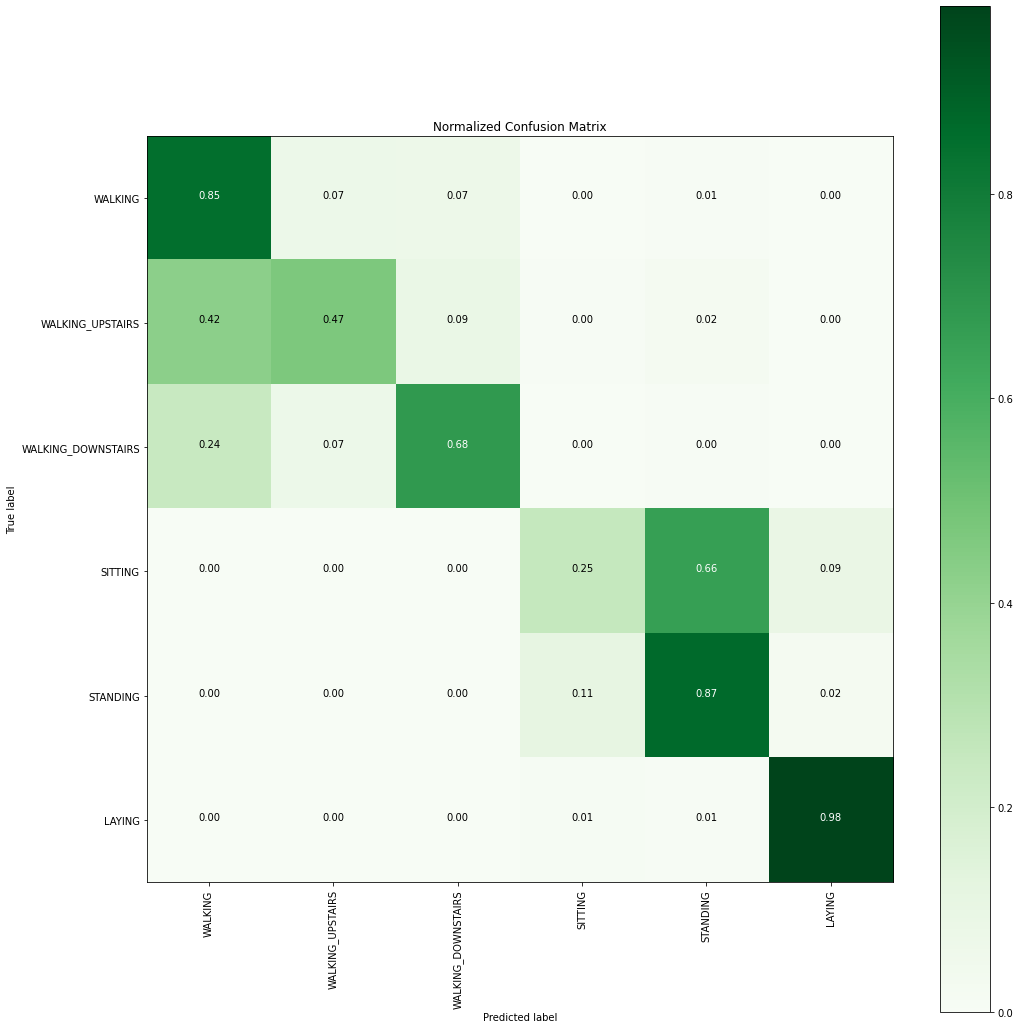


 F1 Score:0.6669733610934858


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6985120862788836


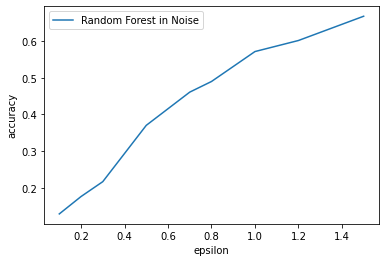

[0.1296725997311253, 0.17691239191222938, 0.21734392338141384, 0.3704012939014385, 0.46070278809385384, 0.48959688027391085, 0.5710009520350171, 0.6010365933552785, 0.6669733610934858]


In [ ]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_har = list()
f1_array_random_har = list()


# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
epsilons = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0, 1.2, 1.5]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  # for feature in f_add_weighted_noise:
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    else :
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

    
  params = {'n_estimators': np.arange(150,201,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_act)
  f1_array_random_har.append(f1)
  acc_array_random_har.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_har[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_har)

In [ ]:
# epsilons = [0.1, 0.3, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 2.0]
# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2]
# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
# epsilons = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0, 1.2, 1.5]
print(f1_array_random_har)
print(f1_array_random_uid)
print(acc_array_random_har)
print(acc_array_random_uid)

[0.1296725997311253, 0.17691239191222938, 0.21734392338141384, 0.3704012939014385, 0.46070278809385384, 0.48959688027391085, 0.5710009520350171, 0.6010365933552785, 0.6669733610934858]
[0.021496516141654782, 0.014939648484416155, 0.018025706903355764, 0.014266574980116619, 0.02183790063388952, 0.016797700921905915, 0.025744840350320815, 0.03649800268653531, 0.05429643924563261]
[0.18116179849031835, 0.26353790613718414, 0.319658680669511, 0.43944863800459466, 0.5264194289465047, 0.549721037085658, 0.6110928782408926, 0.6458811946176567, 0.6921562192320315]
[0.037085658024286185, 0.03675746636035445, 0.039711191335740074, 0.04200853298326222, 0.04168034131933049, 0.03807023301608139, 0.04496225795864785, 0.062356416147029865, 0.07154578273711848]


In [ ]:
print(weighted_epsilon)
print(n)

0.02
119


In [ ]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

In [ ]:
beep()

ModuleNotFoundError: No module named 'google.colab'